# KUBIG 24S NLP Basic HW2

## Preview 1

### 19기 정종락

# Install Library

In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.1 MB/s eta 0:00:00


$$
\\
$$

# Import Library, Module and Dataset

## Library and Module

In [9]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

$$
\\
$$

## Dataset

### 삼성전자

In [5]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df_samsung = fdr.DataReader('005930', '2023-01-01', '2024-12-31')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617
2023-01-03,55400,56000,54500,55400,13547030,-0.001802
2023-01-04,55700,58000,55600,57800,20188071,0.043321
2023-01-05,58200,58800,57600,58200,15682826,0.006920
2023-01-06,58300,59400,57900,59000,17334989,0.013746


In [6]:
df_samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617
2023-01-03,55400,56000,54500,55400,13547030,-0.001802
2023-01-04,55700,58000,55600,57800,20188071,0.043321
2023-01-05,58200,58800,57600,58200,15682826,0.006920
2023-01-06,58300,59400,57900,59000,17334989,0.013746


In [7]:
df_samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-07-11,88500,88800,86700,87600,24677608,-0.002278
2024-07-12,85900,86100,84100,84400,26344386,-0.036530
2024-07-15,84700,87300,84100,86700,25193080,0.027251
2024-07-16,86900,88000,86700,87700,16166688,0.011534
2024-07-17,87100,88000,86400,86700,17745561,-0.011403


$$
\\
$$

# Analysis

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## EDA

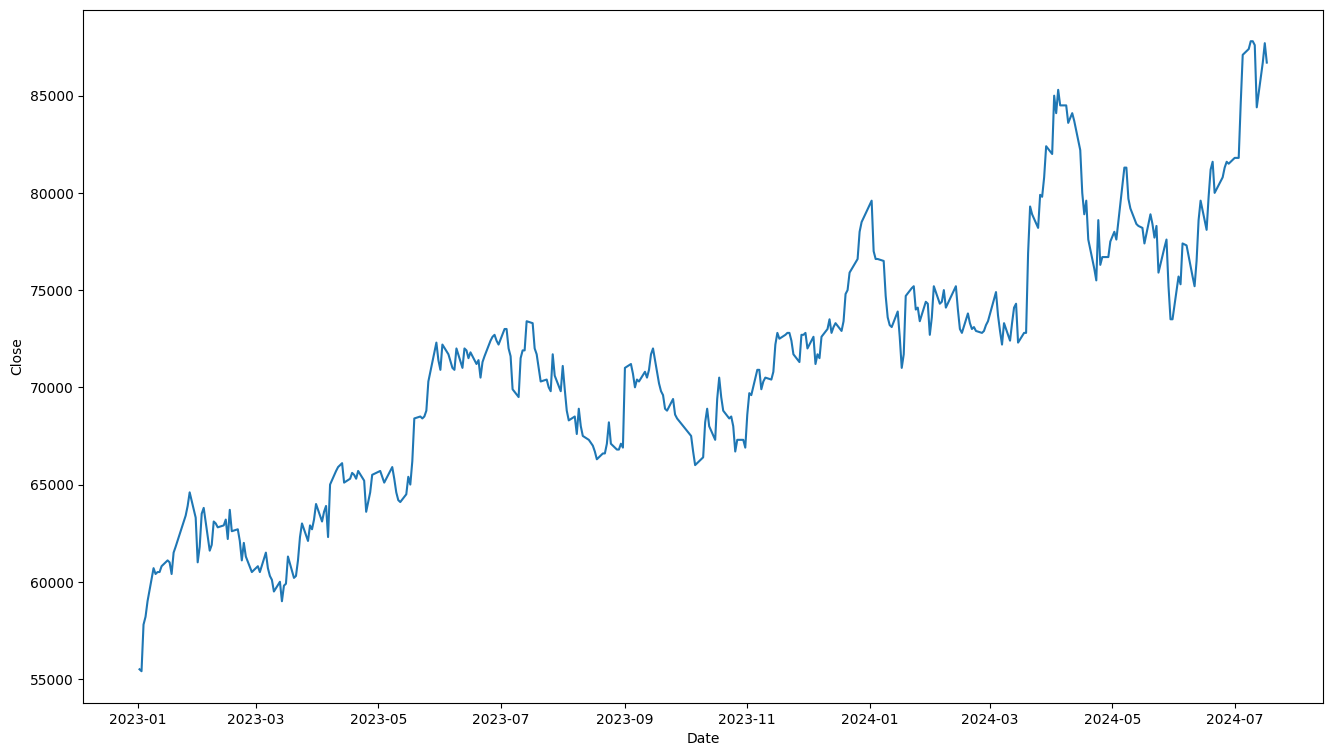

In [13]:
plt.figure(figsize = (16, 9))
sns.lineplot(x = df_samsung.index,
             y = 'Close',
             data = df_samsung)
plt.show()

# Data Preprocessing

## 종가 제외 스케일링 (예측변수 = 종가)

In [14]:
scaler = MinMaxScaler()
df_samsung[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df_samsung[['Open','High', 'Low','Close','Volume']])

$$
\\
$$

## 자료형, Train/Valid set Split

## 넘파이 배열로 변경

In [15]:
x = df_samsung[['Open', 'High', 'Low', 'Volume']].values
y = df_samsung['Close'].values

$$
\\
$$

## 시퀀스 데이터 생성

In [16]:
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  # gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [17]:
split = 200
sequence_length = 5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

<ipython-input-16-f7899bf9b8c7>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


$$
\\
$$

## Split

In [18]:
#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [19]:
x_train_seq

tensor([[[0.0030, 0.0030, 0.0215, 0.0811],
         [0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219]],

        [[0.0000, 0.0000, 0.0000, 0.1489],
         [0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471]],

        [[0.0091, 0.0610, 0.0337, 0.2769],
         [0.0846, 0.0854, 0.0951, 0.1901],
         [0.0876, 0.1037, 0.1043, 0.2219],
         [0.1299, 0.1433, 0.1564, 0.2471],
         [0.1450, 0.1555, 0.1656, 0.1742]],

        ...,

        [[0.4018, 0.3994, 0.4202, 0.1119],
         [0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742, 0.1869],
         [0.3535, 0.3445, 0.3742, 0.1062]],

        [[0.4018, 0.3902, 0.4049, 0.1343],
         [0.4048, 0.3902, 0.4110, 0.0923],
         [0.3505, 0.3628, 0.3742

In [20]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

$$
\\
$$

# Vanila RNN

## 모델 구축

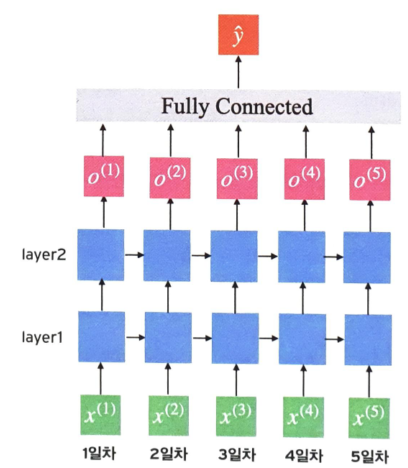

In [23]:
# 기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [24]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [27]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length = sequence_length,
                   num_layers = num_layers,
                   device=device).to(device)

In [32]:
# 설정
criterion = nn.MSELoss()
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

## 모델 학습

In [33]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data # 배치 데이터
    out = model(seq) # 출력값 계산
    loss = criterion(out, target) # 손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0008
[epoch : 10] loss: 0.0008
[epoch : 20] loss: 0.0008
[epoch : 30] loss: 0.0008
[epoch : 40] loss: 0.0008
[epoch : 50] loss: 0.0008
[epoch : 60] loss: 0.0008
[epoch : 70] loss: 0.0008
[epoch : 80] loss: 0.0008
[epoch : 90] loss: 0.0008
[epoch : 100] loss: 0.0008
[epoch : 110] loss: 0.0008
[epoch : 120] loss: 0.0008
[epoch : 130] loss: 0.0008
[epoch : 140] loss: 0.0008
[epoch : 150] loss: 0.0007
[epoch : 160] loss: 0.0008
[epoch : 170] loss: 0.0007
[epoch : 180] loss: 0.0008
[epoch : 190] loss: 0.0008


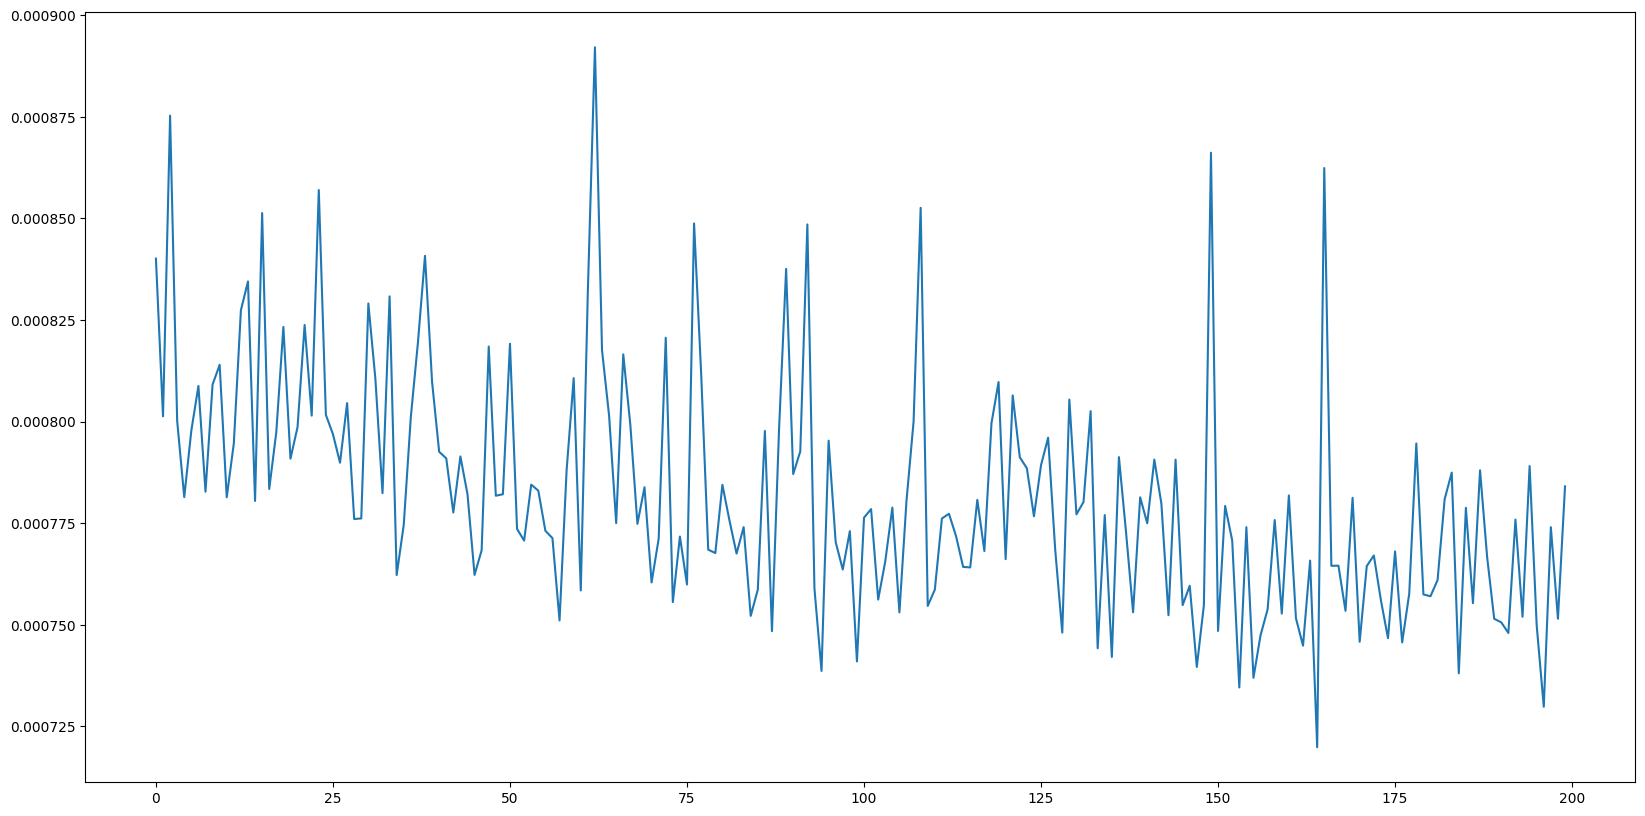

In [34]:
plt.figure(figsize = (20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [35]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

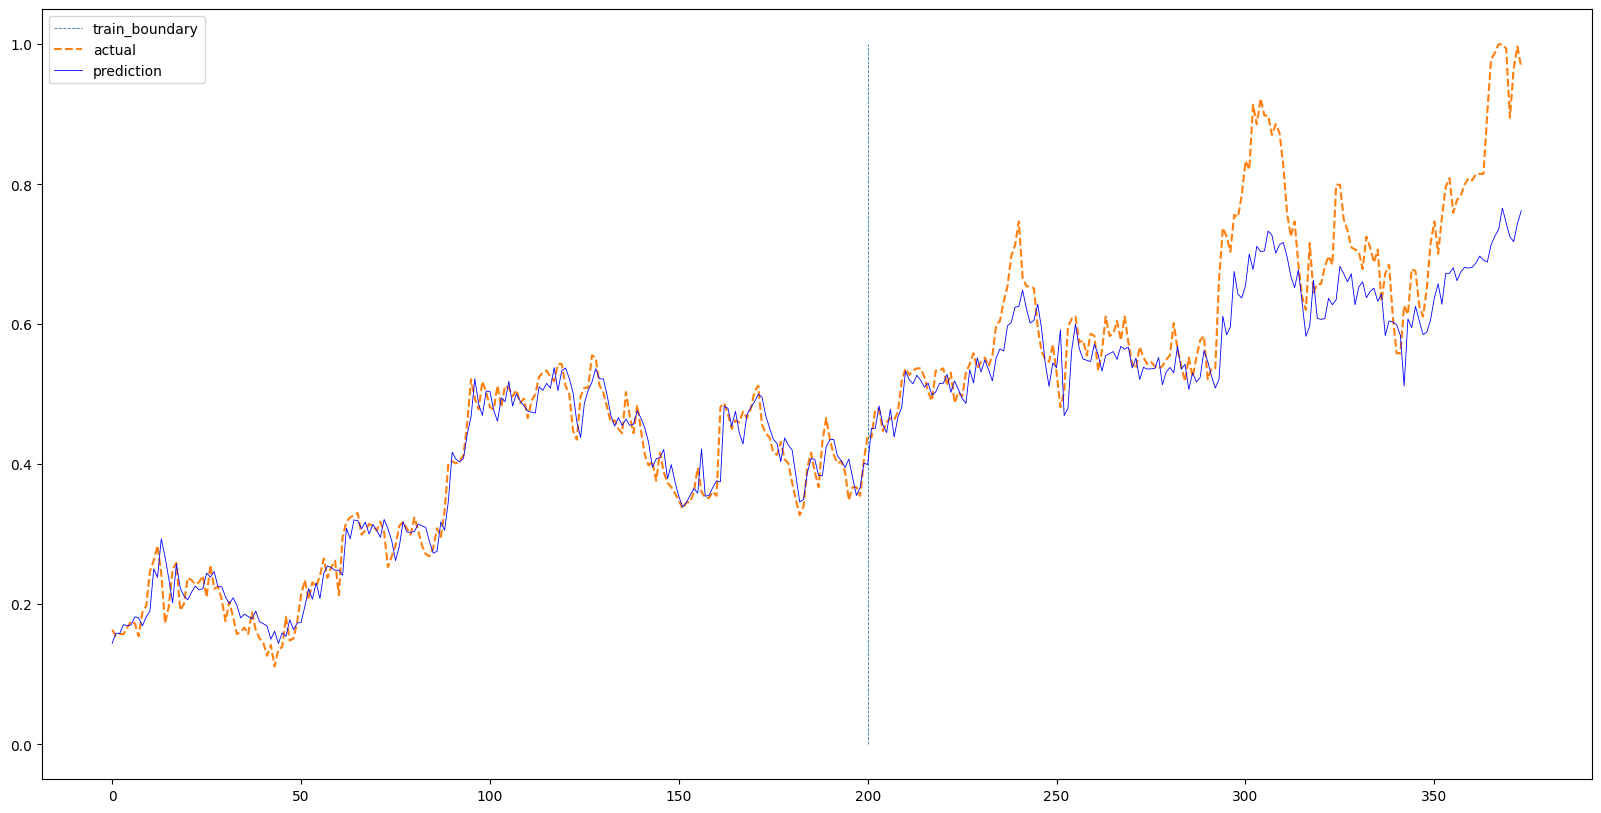

In [37]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train),
         np.linspace(0,1,100), '--', linewidth = 0.6)
plt.plot(df_samsung['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [38]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [39]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [40]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [43]:
criterion = nn.MSELoss()
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [44]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0018
[epoch: 10] loss: 0.0016
[epoch: 20] loss: 0.0014
[epoch: 30] loss: 0.0012
[epoch: 40] loss: 0.0011
[epoch: 50] loss: 0.0013
[epoch: 60] loss: 0.0013
[epoch: 70] loss: 0.0010
[epoch: 80] loss: 0.0009
[epoch: 90] loss: 0.0010
[epoch: 100] loss: 0.0009
[epoch: 110] loss: 0.0009
[epoch: 120] loss: 0.0009
[epoch: 130] loss: 0.0009
[epoch: 140] loss: 0.0009
[epoch: 150] loss: 0.0009
[epoch: 160] loss: 0.0009
[epoch: 170] loss: 0.0009
[epoch: 180] loss: 0.0010
[epoch: 190] loss: 0.0008


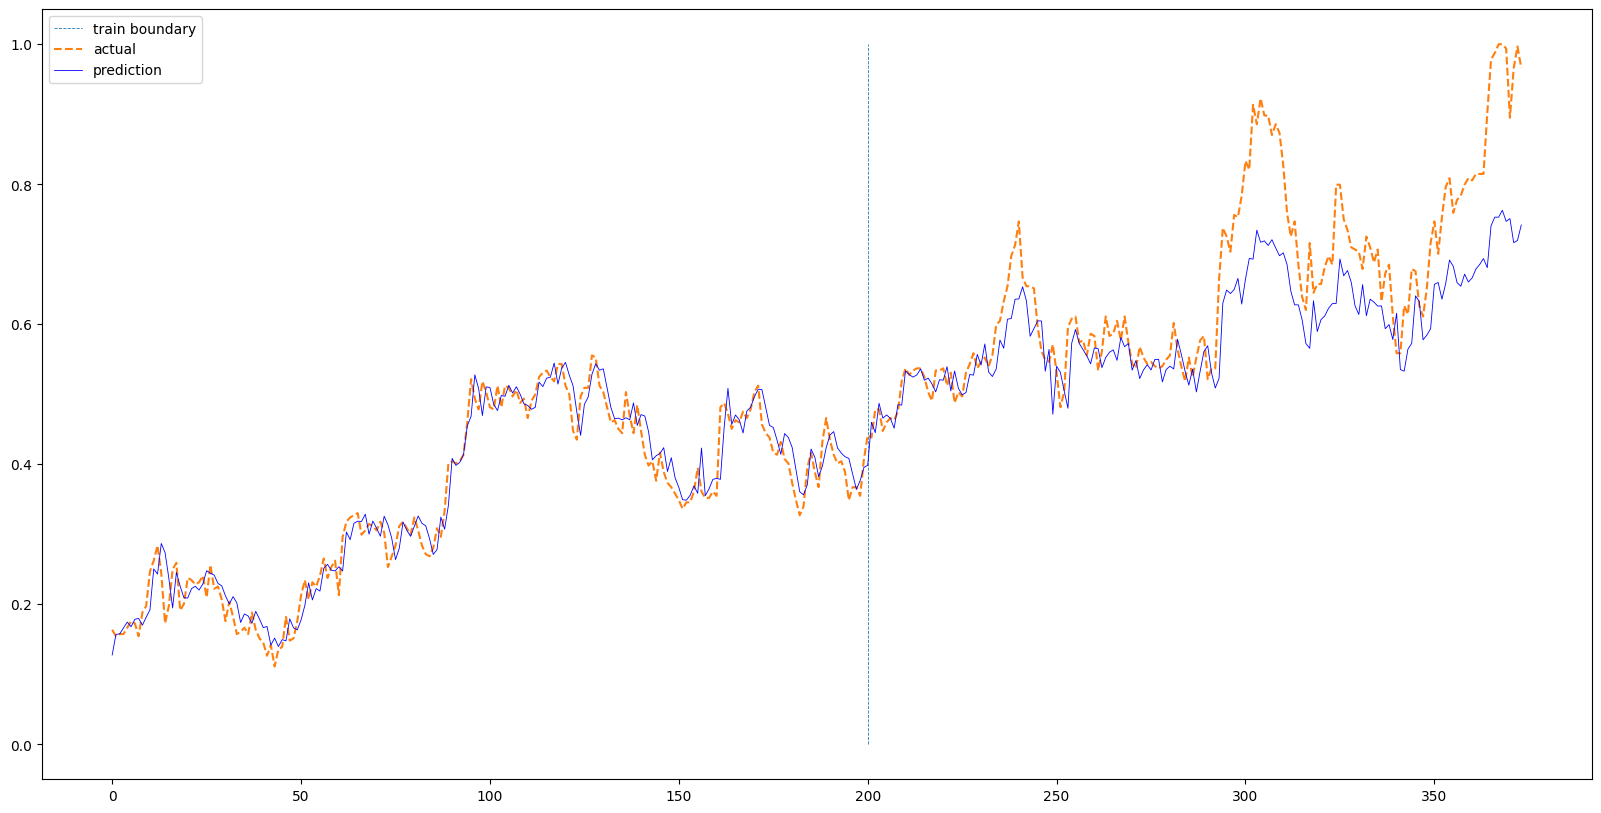

In [45]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size = 100, shuffle = False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),
         np.linspace(0,1,100), '--', linewidth = 0.6)
plt.plot(df_samsung['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail